In [20]:
import pickle
import pandas as pd
import os
from tqdm import tqdm
from scripts.plots_and_evaluation import evaluate_model, plots_and_evaluation

In [21]:
# Example parameters (you may customize these)
df_path = 'datasets\job_melt_complete_data_2024.csv'
remaining_feature_groups_idxs = [2, 4, 5, 6, 8, 9, 10]
feature_prefixes = ['covid', 'indeed', 'inf_VALUE_Bank rate', 'inf_VALUE_Target rate',
                    'cpi_VALUE', 'gdp_VALUE', 'bus', 'job', 'ear', 'emp', 'hou']
plots_dir = "Final_run-J-08-20"
model_name = 'lag-llama'
datasets = [('job', 'datasets\job_melt_complete_data_2024.csv', 5.2)]


In [22]:
df = pd.read_csv(df_path)

# Compile final selected features based on remaining indices
feature_groups = [
    [col for col in df.columns if col.startswith(prefix)] 
    for prefix in feature_prefixes
]
final_selected_features = [feature for idx in remaining_feature_groups_idxs for feature in feature_groups[idx]]

# Ensure the results directory exists
os.makedirs(plots_dir, exist_ok=True)
# Evaluate models and save plots
results = []
best_score = float('inf')

Processing datasets:   0%|          | 0/1 [00:00<?, ?it/s]

Processing job with 5.2 context_length factor


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params
-----------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M 
1 | augmentations | ApplyAugmentations | 0     
-----------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved. New best score: 10.113
Epoch 0, global step 50: 'val_loss' reached 10.11287 (best 10.11287), saving model to 'c:\\Users\\Abdul-AzizAlNajjar\\CU\\DATA 5001\\forcasting-labour-indicators\\lightning_logs\\version_26\\checkpoints\\epoch=0-step=50.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.319 >= min_delta = 0.0. New best score: 9.794
Epoch 1, global step 100: 'val_loss' reached 9.79370 (best 9.79370), saving model to 'c:\\Users\\Abdul-AzizAlNajjar\\CU\\DATA 5001\\forcasting-labour-indicators\\lightning_logs\\version_26\\checkpoints\\epoch=1-step=100.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 150: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, global step 200: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.075 >= min_delta = 0.0. New best score: 9.719
Epoch 4, global step 250: 'val_loss' reached 9.71876 (best 9.71876), saving model to 'c:\\Users\\Abdul-AzizAlNajjar\\CU\\DATA 5001\\forcasting-labour-indicators\\lightning_logs\\version_26\\checkpoints\\epoch=4-step=250.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 5, global step 300: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.032 >= min_delta = 0.0. New best score: 9.687
Epoch 6, global step 350: 'val_loss' reached 9.68696 (best 9.68696), saving model to 'c:\\Users\\Abdul-AzizAlNajjar\\CU\\DATA 5001\\forcasting-labour-indicators\\lightning_logs\\version_26\\checkpoints\\epoch=6-step=350.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 7, global step 400: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 8, global step 450: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.077 >= min_delta = 0.0. New best score: 9.610
Epoch 9, global step 500: 'val_loss' reached 9.61002 (best 9.61002), saving model to 'c:\\Users\\Abdul-AzizAlNajjar\\CU\\DATA 5001\\forcasting-labour-indicators\\lightning_logs\\version_26\\checkpoints\\epoch=9-step=500.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.060 >= min_delta = 0.0. New best score: 9.550
Epoch 10, global step 550: 'val_loss' reached 9.54982 (best 9.54982), saving model to 'c:\\Users\\Abdul-AzizAlNajjar\\CU\\DATA 5001\\forcasting-labour-indicators\\lightning_logs\\version_26\\checkpoints\\epoch=10-step=550.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.103 >= min_delta = 0.0. New best score: 9.447
Epoch 11, global step 600: 'val_loss' reached 9.44676 (best 9.44676), saving model to 'c:\\Users\\Abdul-AzizAlNajjar\\CU\\DATA 5001\\forcasting-labour-indicators\\lightning_logs\\version_26\\checkpoints\\epoch=11-step=600.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 12, global step 650: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 13, global step 700: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 9.440
Epoch 14, global step 750: 'val_loss' reached 9.44015 (best 9.44015), saving model to 'c:\\Users\\Abdul-AzizAlNajjar\\CU\\DATA 5001\\forcasting-labour-indicators\\lightning_logs\\version_26\\checkpoints\\epoch=14-step=750.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 15, global step 800: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.021 >= min_delta = 0.0. New best score: 9.419
Epoch 16, global step 850: 'val_loss' reached 9.41920 (best 9.41920), saving model to 'c:\\Users\\Abdul-AzizAlNajjar\\CU\\DATA 5001\\forcasting-labour-indicators\\lightning_logs\\version_26\\checkpoints\\epoch=16-step=850.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 17, global step 900: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 18, global step 950: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 9.418
Epoch 19, global step 1000: 'val_loss' reached 9.41804 (best 9.41804), saving model to 'c:\\Users\\Abdul-AzizAlNajjar\\CU\\DATA 5001\\forcasting-labour-indicators\\lightning_logs\\version_26\\checkpoints\\epoch=19-step=1000.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 20, global step 1050: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 21, global step 1100: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.105 >= min_delta = 0.0. New best score: 9.313
Epoch 22, global step 1150: 'val_loss' reached 9.31261 (best 9.31261), saving model to 'c:\\Users\\Abdul-AzizAlNajjar\\CU\\DATA 5001\\forcasting-labour-indicators\\lightning_logs\\version_26\\checkpoints\\epoch=22-step=1150.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 23, global step 1200: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 24, global step 1250: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 25, global step 1300: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 26, global step 1350: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 27, global step 1400: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 28, global step 1450: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 29, global step 1500: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 30, global step 1550: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.071 >= min_delta = 0.0. New best score: 9.242
Epoch 31, global step 1600: 'val_loss' reached 9.24209 (best 9.24209), saving model to 'c:\\Users\\Abdul-AzizAlNajjar\\CU\\DATA 5001\\forcasting-labour-indicators\\lightning_logs\\version_26\\checkpoints\\epoch=31-step=1600.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 32, global step 1650: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 33, global step 1700: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 34, global step 1750: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 35, global step 1800: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 36, global step 1850: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 37, global step 1900: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 38, global step 1950: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 39, global step 2000: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 40, global step 2050: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 41, global step 2100: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 42, global step 2150: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 43, global step 2200: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 44, global step 2250: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 45, global step 2300: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Monitored metric val_loss did not improve in the last 15 records. Best score: 9.242. Signaling Trainer to stop.
Epoch 46, global step 2350: 'val_loss' was not in top 1


Forecasting batches:   0%|          | 0/21 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/21 [00:00<?, ?it/s]

Running evaluation: 21it [00:00, 238.61it/s]
Processing datasets: 100%|██████████| 1/1 [01:33<00:00, 93.69s/it]


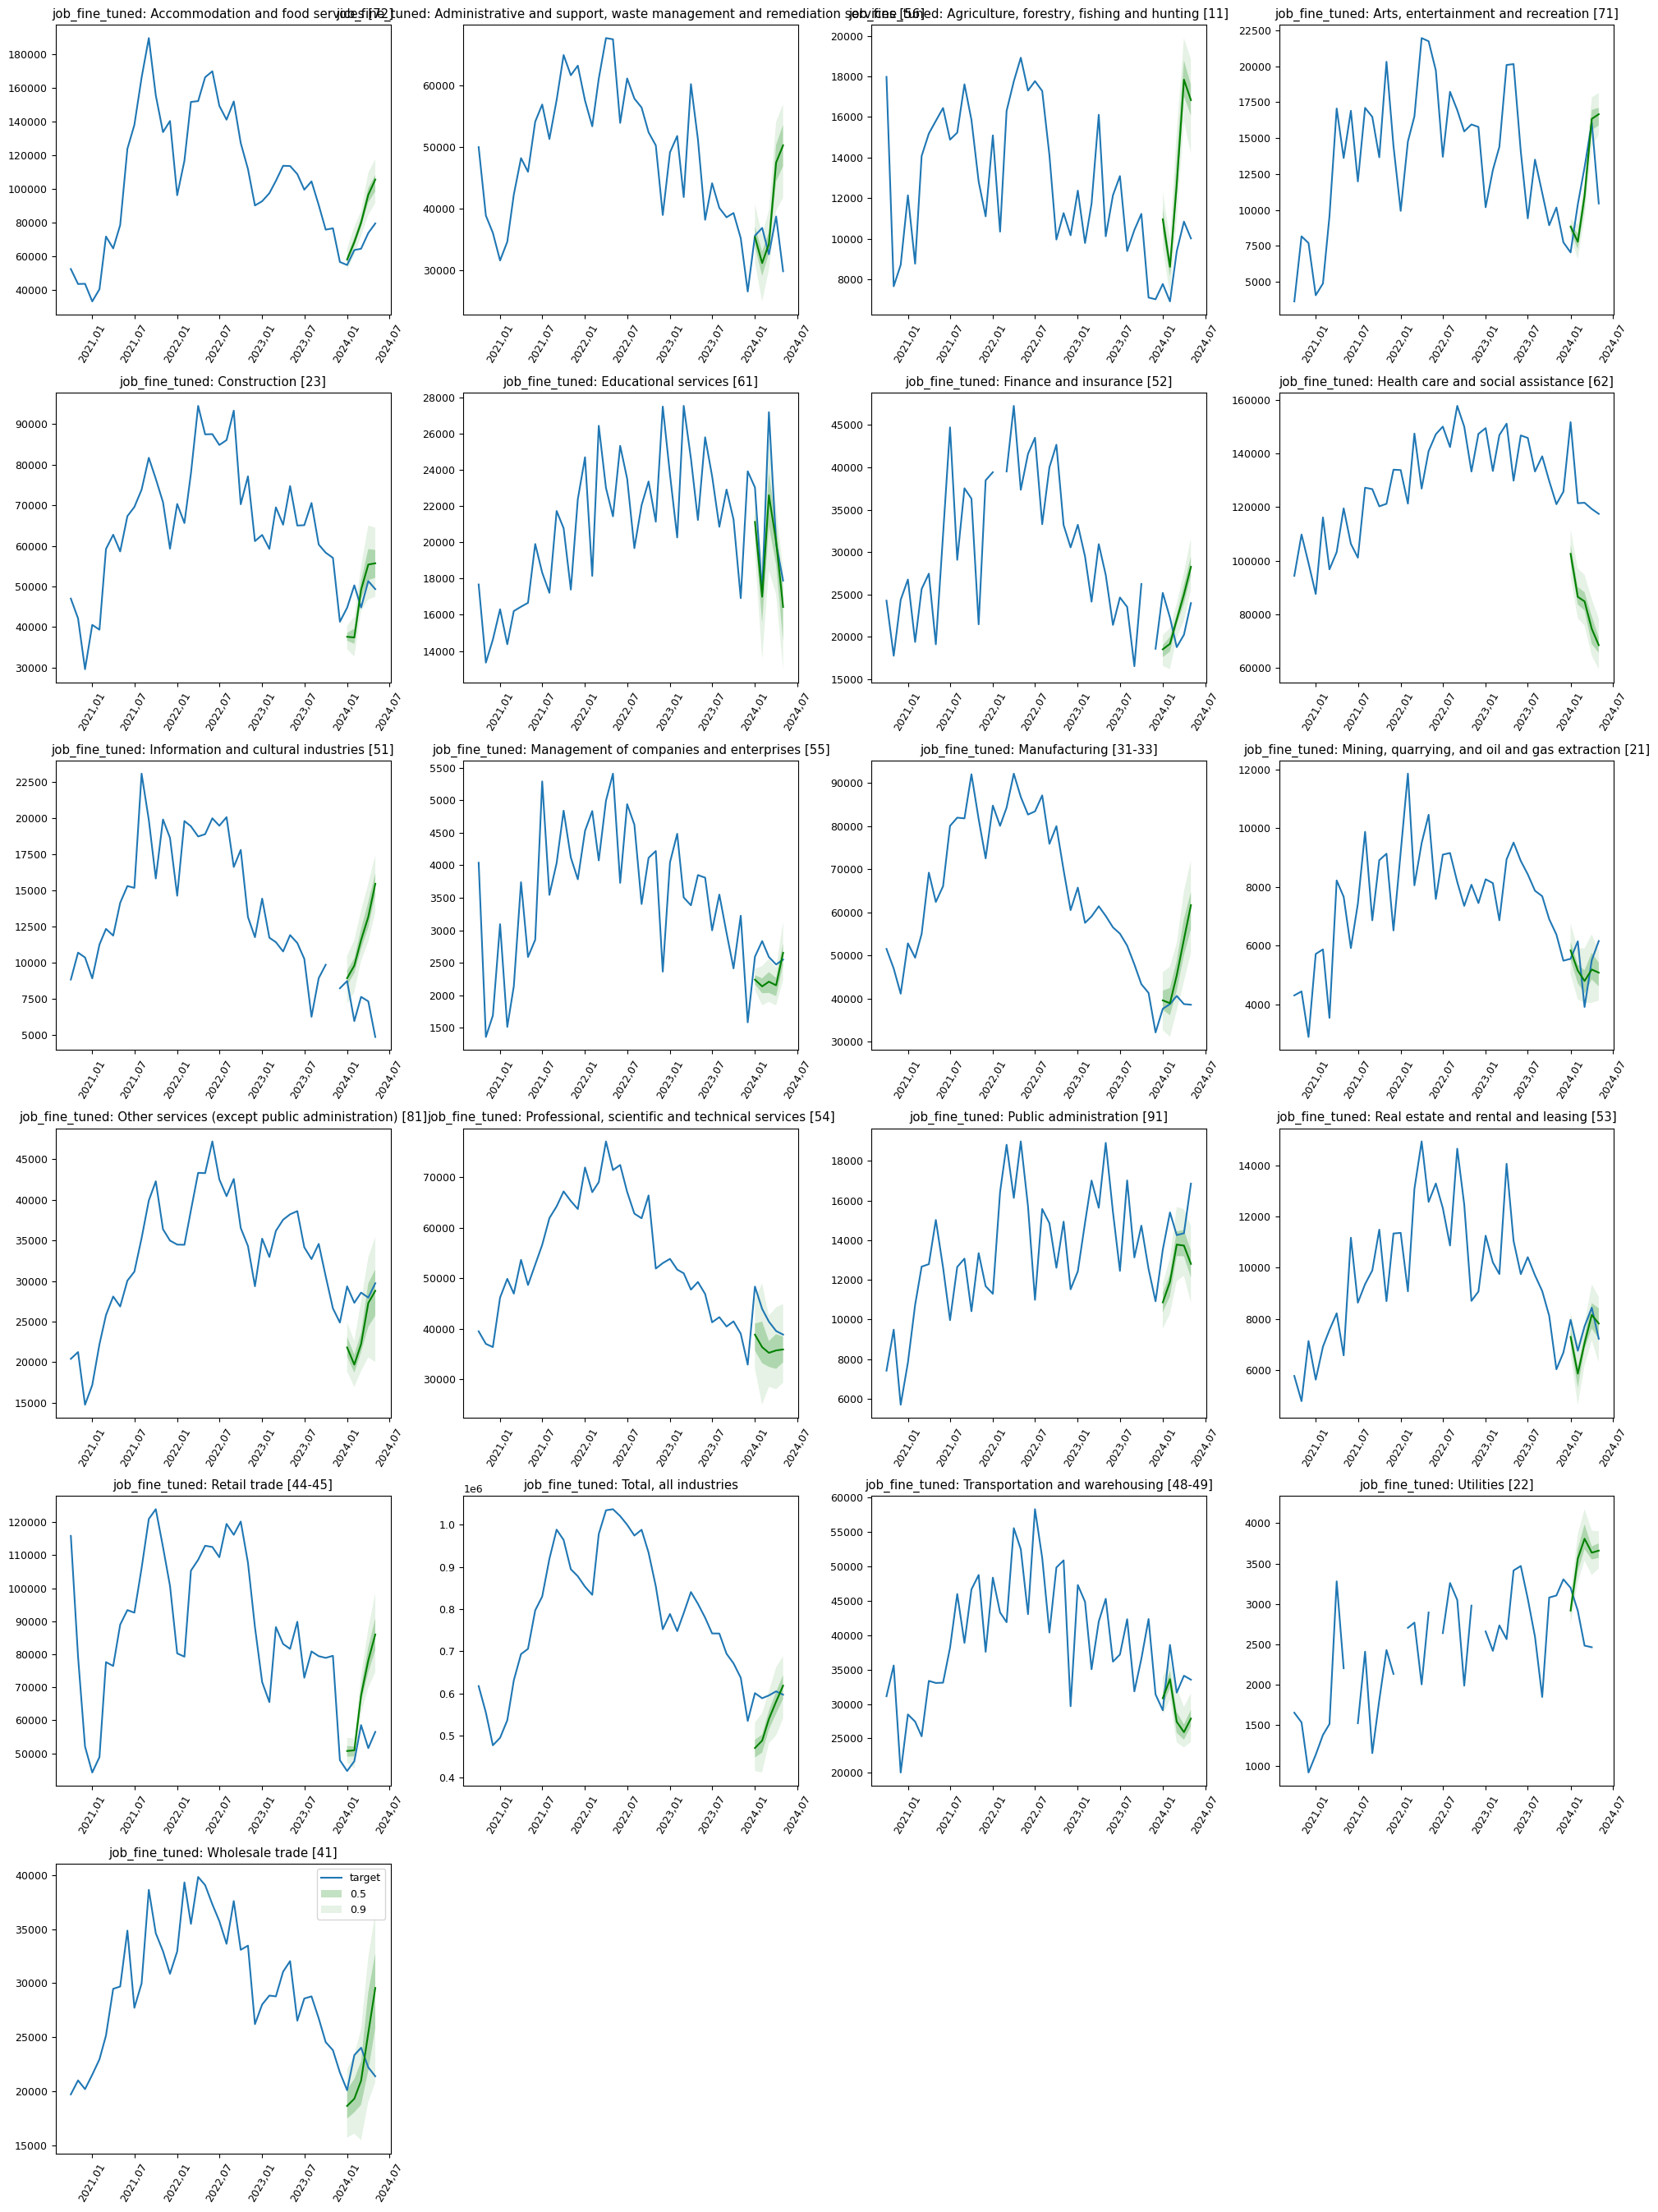

In [26]:
for dataset_name, path_to_csv, cl in tqdm(datasets, desc=f"Processing datasets"):
    best_score = float('inf')
    print(f'Processing {dataset_name} with {cl} context_length factor')
    for i in range(1):
        for model_type in ['fine_tuned']:
            result = evaluate_model(model_name, dataset_name, path_to_csv, model_type,
                                    prediction_length=5, # orignal 11
                                    with_external=True, context_length_factor=cl,
                                    selected_features=final_selected_features)

            results.append(result)
            if result.overall_mase < best_score:
                best_score = result.overall_mase
                best_result = result

                # File path for the result pickle file
                result_pickle_path = os.path.join(plots_dir, f'MASE_{result.dataset_name}_best_result.pkl')

                # Check if the file exists and delete it if it does
                if os.path.exists(result_pickle_path):
                    os.remove(result_pickle_path)

                # Save the new best result
                with open(result_pickle_path, 'wb') as f:
                    pickle.dump(best_result, f)

            # Save plots
            plot_obj = plots_and_evaluation(forecasts=result.forecasts, tss=result.ts, title=dataset_name + '_' + model_type)
            save_path = os.path.join(plots_dir, f"{i}_MASE_{result.dataset_name}_{cl}_forecasts.png")
            plot_obj.plot_forcasts_all(save_path=save_path)

            # Create DataFrame
            results_df = pd.DataFrame([result.to_dict() for result in results])


In [28]:
result.ts[1]

,0
2001-01,NaN
2001-02,NaN
2001-03,NaN
2001-04,NaN
2001-05,NaN
...,...
2024-01,35645.0
2024-02,36910.0
2024-03,32635.0
2024-04,38765.0
